# Experimentación de Modelos

En este notebook se desarrollan y evalúan distintos enfoques de modelado para la predicción de la cantidad de unidades vendidas a nivel **día/producto/transacción**.  

Los objetivos principales son:  
- Preparar los datos de entrenamiento a partir del pipeline procesado.  
- Entrenar y comparar diferentes familias de modelos:  
  - **Modelos estadísticos** (ej. Exponential Smoothing).  
  - **Modelos de machine learning** (Random Forest, LightGBM, XGBoost).  
  - **Modelos de deep learning** (ej. LSTM).  
- Evaluar el desempeño mediante métricas de error (MAE, RMSE).  
- Documentar observaciones relevantes de cada experimento.  

Este notebook constituye la base para la selección del mejor modelo, cuyos resultados serán analizados y comparados en el notebook `03_results_analysis.ipynb`.


In [1]:
#revisando data
import pandas as pd
import numpy as np
# Ejecuta esto para diagnosticar
print("=== DIAGNÓSTICO DEL PIPELINE ===")

# 1. Revisar data_cleaned
df_cleaned = pd.read_parquet('../data/processed/data_cleaned.parquet')
print(f"data_cleaned: {df_cleaned.shape}")

# 2. Revisar data_processed  
df_processed = pd.read_parquet('../data/processed/data_processed.parquet')
print(f"data_processed: {df_processed.shape}")

# 3. Revisar data_training
df_training = pd.read_parquet('../data/processed/data_training.parquet')
print(f"data_training: {df_training.shape}")

# 4. Revisar datos originales
df_raw = pd.read_parquet('../data/raw/data_sample.parquet')
print(f"data_sample (raw): {df_raw.shape}")

#if 'product_quantity' in df_cleaned.columns:
#    print("\nEn datos CLEANED:")
#    print(f"  - > 0: {(df_cleaned['product_quantity'] > 0).sum()}")
#    print(f"  - == 0: {(df_cleaned['product_quantity'] == 0).sum()}")
#    print(f"  - Distribución:")
#    print(df_cleaned['product_quantity'].value_counts().sort_index().head(10))

=== DIAGNÓSTICO DEL PIPELINE ===
data_cleaned: (36242, 79)
data_processed: (36242, 101)
data_training: (25521, 24)
data_sample (raw): (74457, 77)


Producto: GGOEGFKQ020399


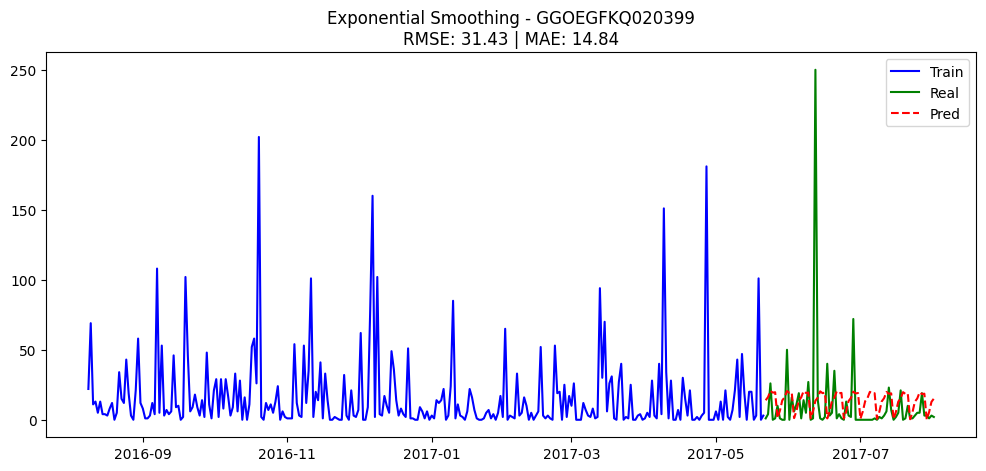

Producto: GGOEGHGC019799


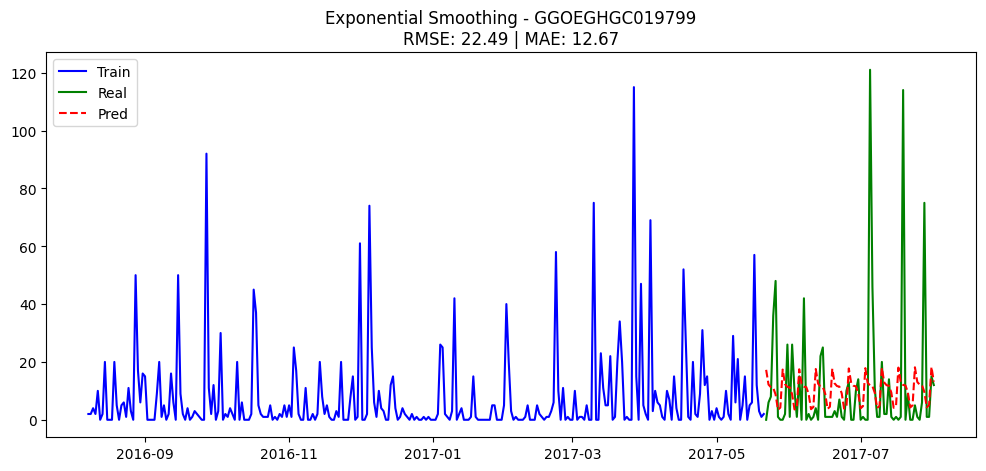

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Agregar a nivel día-producto
df_daily = df_training.groupby(['parsed_date', 'product_sku'])['units_sold'].sum().reset_index()

# Seleccionar productos top
top_products = df_daily['product_sku'].value_counts().head(2).index

for sku in top_products:
    print(f"Producto: {sku}")
    
    # Serie temporal del producto
    product_ts = df_daily[df_daily['product_sku'] == sku]
    ts = product_ts.set_index('parsed_date')['units_sold'].asfreq('D').fillna(0)
    
    if len(ts) < 40:
        continue

    # Train/test split
    split = int(len(ts) * 0.8)
    train, test = ts.iloc[:split], ts.iloc[split:]
    
    if len(test) == 0:
        continue

    # Exponential Smoothing
    model = ExponentialSmoothing(
        train,
        trend="add",
        seasonal="add", 
        seasonal_periods=7
    ).fit()

    pred = model.forecast(len(test))
    
    # Métricas
    rmse = np.sqrt(mean_squared_error(test, pred))
    mae = mean_absolute_error(test, pred)
    
    # Gráfico
    plt.figure(figsize=(12,5))
    plt.plot(train.index, train, label="Train", color="blue")
    plt.plot(test.index, test, label="Real", color="green") 
    plt.plot(test.index, pred, label="Pred", color="red", linestyle="--")
    plt.title(f"Exponential Smoothing - {sku}\nRMSE: {rmse:.2f} | MAE: {mae:.2f}")
    plt.legend()
    plt.show()

    

🚀 ENTRENANDO XGBOOST
📊 Datos finales: 17616 filas
🔧 Productos: 127
📈 Train: 14121, Test: 3495

✅ XGBOOST RESULTS:
RMSE: 4.2867
MAE:  2.9325


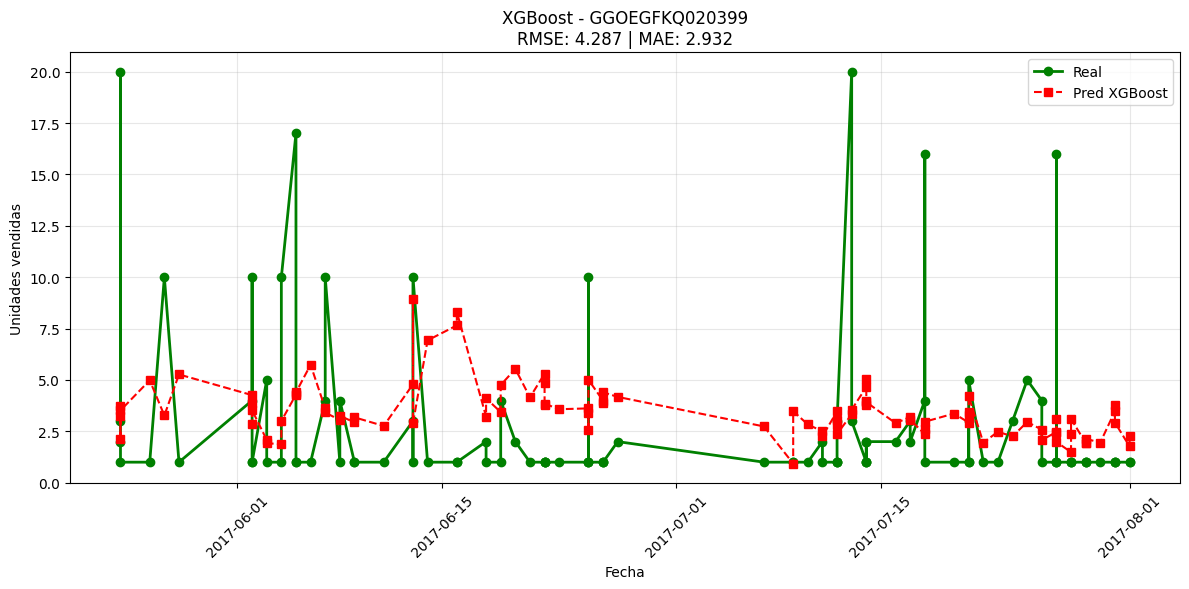

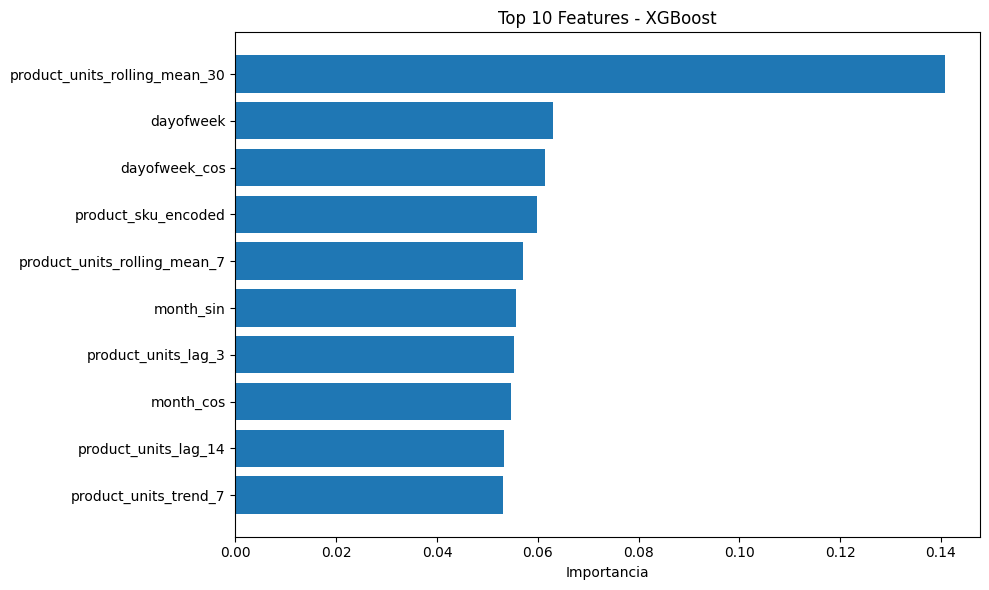


🎯 XGBoost entrenado: RMSE 4.287, MAE 2.932


In [3]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Configuración
plt.style.use('default')

print("🚀 ENTRENANDO XGBOOST")

# 1. PREPARAR DATOS
df_model = df_training.copy()

# Filtrar outliers y productos con suficiente historial
df_filtered = df_model[df_model['units_sold'] <= 20].copy()
product_counts = df_filtered['product_sku'].value_counts()
products_50plus = product_counts[product_counts >= 50].index
df_filtered = df_filtered[df_filtered['product_sku'].isin(products_50plus)]

print(f"📊 Datos finales: {len(df_filtered)} filas")
print(f"🔧 Productos: {len(products_50plus)}")

# 2. DEFINIR FEATURES
available_features = [
    'year', 'month', 'day', 'dayofweek', 'is_weekend', 
    'is_month_start', 'is_month_end', 'month_sin', 'month_cos',
    'dayofweek_sin', 'dayofweek_cos', 'product_units_lag_1',
    'product_units_lag_3', 'product_units_lag_7', 'product_units_lag_14',
    'product_units_rolling_mean_7', 'product_units_rolling_mean_30',
    'product_units_trend_7', 'days_since_last_transaction'
]

available_features = [col for col in available_features if col in df_filtered.columns]

# Codificar producto
le = LabelEncoder()
df_filtered['product_sku_encoded'] = le.fit_transform(df_filtered['product_sku'])
available_features.append('product_sku_encoded')

# 3. DIVIDIR DATOS
df_sorted = df_filtered.sort_values('parsed_date')
split_date = df_sorted['parsed_date'].quantile(0.8)

train_mask = df_sorted['parsed_date'] <= split_date
test_mask = df_sorted['parsed_date'] > split_date

X_train = df_sorted.loc[train_mask, available_features]
X_test = df_sorted.loc[test_mask, available_features]
y_train = df_sorted.loc[train_mask, 'units_sold']
y_test = df_sorted.loc[test_mask, 'units_sold']

print(f"📈 Train: {len(X_train)}, Test: {len(X_test)}")

# 4. MODELO XGBOOST
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# 5. PREDICCIONES Y MÉTRICAS
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"\n✅ XGBOOST RESULTS:")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE:  {mae_xgb:.4f}")

# 6. GRÁFICO
test_indices = df_sorted[test_mask].index
test_products = df_sorted[test_mask]['product_sku'].value_counts().head(3)

for product_sku, count in test_products.items():
    product_mask = (df_sorted['product_sku'] == product_sku) & test_mask
    if product_mask.sum() > 1:
        product_test_indices = df_sorted[product_mask].index
        mask_positions = [i for i, idx in enumerate(test_indices) if idx in product_test_indices]
        
        y_real_product = y_test.loc[product_test_indices]
        y_pred_product = y_pred_xgb[mask_positions]
        dates_product = df_sorted.loc[product_test_indices, 'parsed_date']
        
        plt.figure(figsize=(12, 6))
        plt.plot(dates_product, y_real_product, label='Real', marker='o', color='green', linewidth=2)
        plt.plot(dates_product, y_pred_product, label='Pred XGBoost', marker='s', color='red', linestyle='--')
        plt.title(f'XGBoost - {product_sku}\nRMSE: {rmse_xgb:.3f} | MAE: {mae_xgb:.3f}')
        plt.xlabel('Fecha')
        plt.ylabel('Unidades vendidas')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        break

# 7. FEATURE IMPORTANCE
feature_imp_xgb = pd.DataFrame({
    'feature': available_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top_features = feature_imp_xgb.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importancia')
plt.title('Top 10 Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n🎯 XGBoost entrenado: RMSE {rmse_xgb:.3f}, MAE {mae_xgb:.3f}")

🧠 LSTM PARA 5 PRODUCTOS ESPECÍFICOS
📦 Top 5 productos seleccionados:
  1. GGOEGFKQ020399 (706 registros)
  2. GGOEGDHC018299 (390 registros)
📊 Datos totales para 5 productos: 1096 filas
📈 Train: (868, 10, 6), Test: (218, 10, 6)
📦 Distribución productos en test: {'GGOEGFKQ020399': 142, 'GGOEGDHC018299': 76}
🔄 LSTM para 5 productos:
ProductLSTM(
  (lstm): LSTM(6, 16, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)
🚀 Entrenando LSTM para 5 productos...
Época [20/100], Loss: 1.0063, Val Loss: 1.0348


c:\Users\geral\Desktop\UPC\DataScience\pc1_20252_metodologia_data_science\myenv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Época [40/100], Loss: 0.9743, Val Loss: 0.9999
Época [60/100], Loss: 0.9489, Val Loss: 0.9625
Época [80/100], Loss: 0.9391, Val Loss: 0.9511
Época [100/100], Loss: 0.9303, Val Loss: 0.9566

✅ LSTM PARA 5 PRODUCTOS - RESULTADOS GENERALES:
RMSE Total: 4.6248
MAE Total:  3.3084

📊 RESULTADOS POR PRODUCTO:
  GGOEGFKQ020399: RMSE 3.9610, MAE 2.7776 (142 muestras)
  GGOEGDHC018299: RMSE 5.6601, MAE 4.3001 (76 muestras)


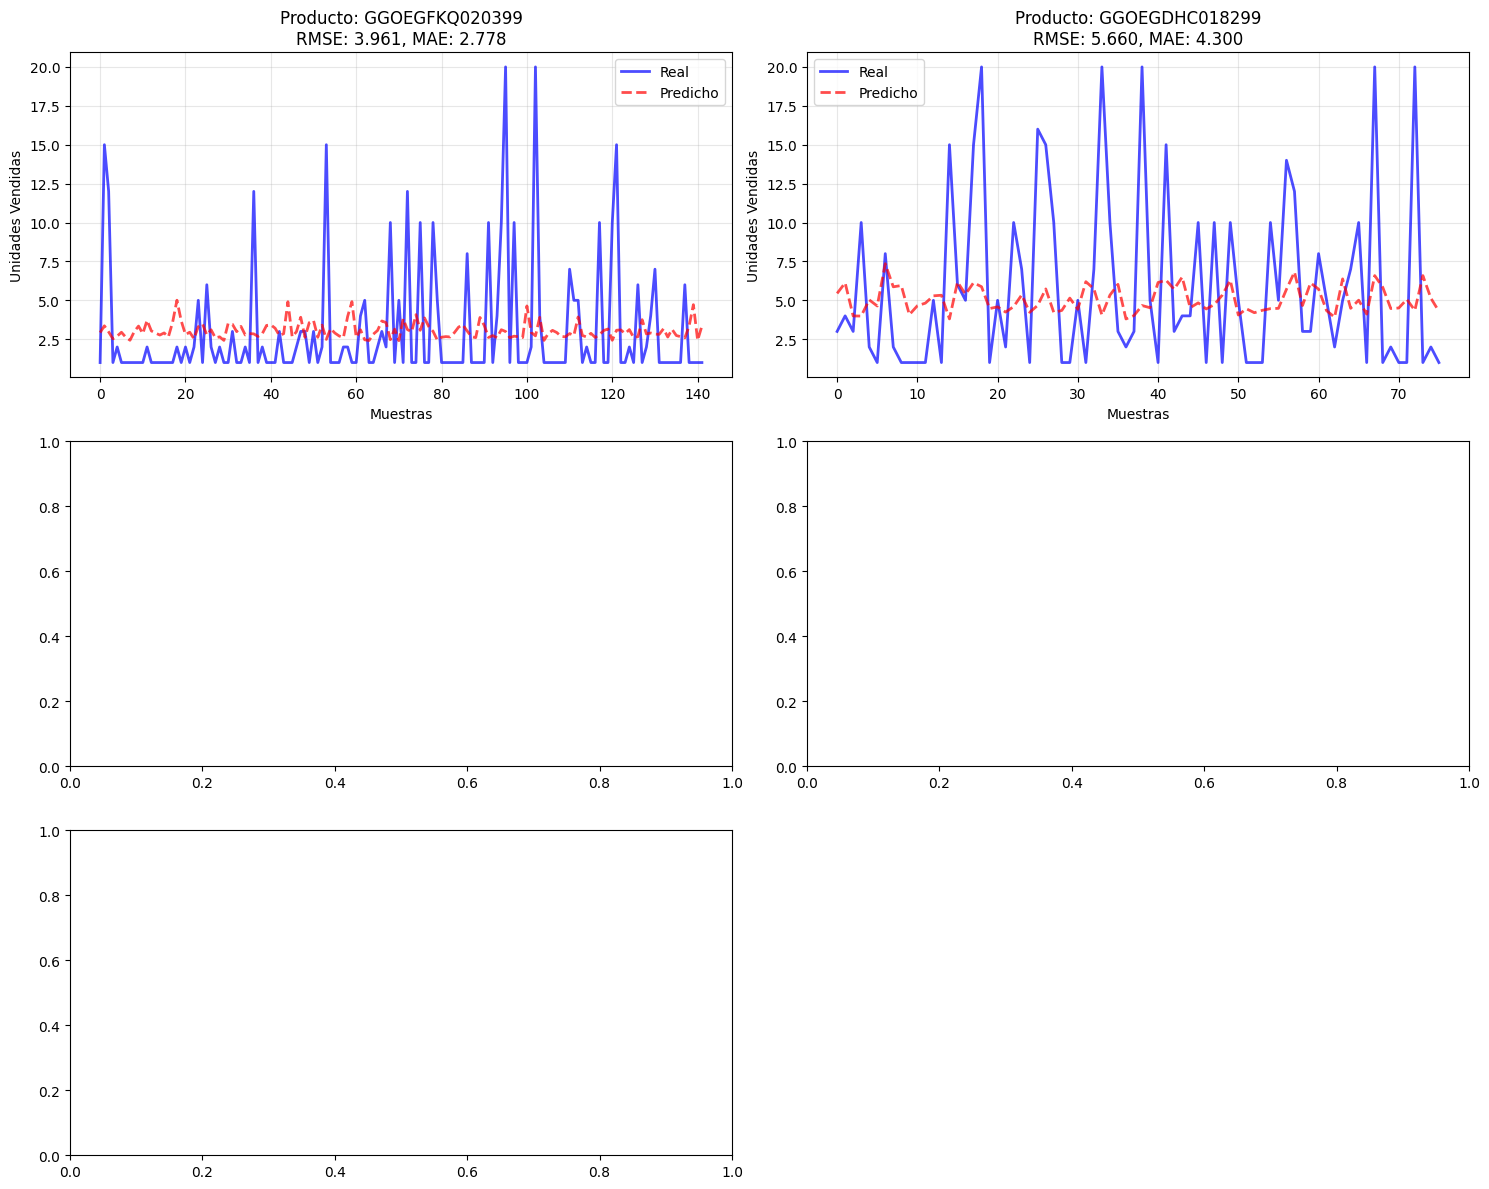

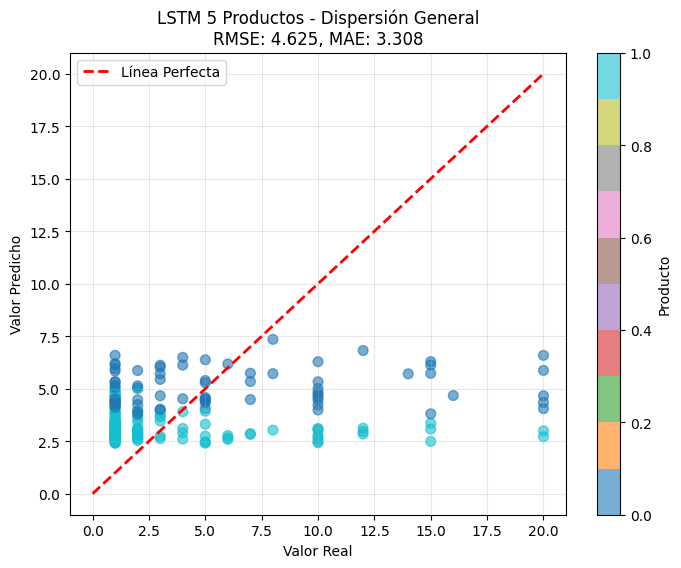


🎯 LSTM para 5 productos completado!
📈 Total: RMSE 4.625, MAE 3.308


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("🧠 LSTM PARA 5 PRODUCTOS ESPECÍFICOS")

# 1. ESCOGER LOS 5 PRODUCTOS MÁS FRECUENTES
top_5_products = df_filtered['product_sku'].value_counts().head(2).index
print("📦 Top 5 productos seleccionados:")
for i, sku in enumerate(top_5_products, 1):
    count = len(df_filtered[df_filtered['product_sku'] == sku])
    print(f"  {i}. {sku} ({count} registros)")

# 2. FILTRAR 
df_5_products = df_filtered[df_filtered['product_sku'].isin(top_5_products)].copy()

# Re-encode los SKUs para que sean 0-4
le = LabelEncoder()
df_5_products['product_sku_encoded'] = le.fit_transform(df_5_products['product_sku'])

print(f"📊 Datos totales para 5 productos: {len(df_5_products)} filas")

# 3. FEATURES SIMPLES
features_simple = [
    'month_sin', 'month_cos',
    'product_units_lag_1', 'product_units_lag_7',
    'product_units_rolling_mean_7',
    'product_sku_encoded'  # Importante: identificar el producto
]
features_simple = [f for f in features_simple if f in df_5_products.columns]

# Escalar
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(df_5_products[features_simple])
y_scaled = scaler_y.fit_transform(df_5_products[['units_sold']])

# 4. CREAR SECUENCIAS
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

time_steps = 10
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, time_steps)

# 5. DIVIDIR DATOS MANTENIENDO PROPORCIÓN POR PRODUCTO
from sklearn.model_selection import train_test_split

# Obtener índices y productos correspondientes a cada secuencia
sequence_indices = np.arange(time_steps, len(df_5_products))
sequence_products = df_5_products.iloc[time_steps:]['product_sku'].values

# Split estratificado por producto
X_train_seq, X_test_seq, y_train_seq, y_test_seq, train_products, test_products = train_test_split(
    X_sequences, y_sequences, sequence_products, test_size=0.2, 
    stratify=sequence_products, random_state=42
)

print(f"📈 Train: {X_train_seq.shape}, Test: {X_test_seq.shape}")
print(f"📦 Distribución productos en test: {pd.Series(test_products).value_counts().to_dict()}")

# 6. MODELO LSTM SIMPLIFICADO
class ProductLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=16, output_size=1):
        super(ProductLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

# Crear modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ProductLSTM(input_size=X_train_seq.shape[2]).to(device)

print("🔄 LSTM para 5 productos:")
print(model)

# 7. ENTRENAR
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

X_train_tensor = torch.FloatTensor(X_train_seq).to(device)
y_train_tensor = torch.FloatTensor(y_train_seq).to(device)
X_test_tensor = torch.FloatTensor(X_test_seq).to(device)
y_test_tensor = torch.FloatTensor(y_test_seq).to(device)

print("🚀 Entrenando LSTM para 5 productos...")

best_val_loss = float('inf')
best_model_state = None

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
    
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 20 == 0:
        print(f'Época [{epoch+1}/100], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Cargar mejor modelo
model.load_state_dict(best_model_state)

# 8. PREDICCIONES
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()

y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_lstm = scaler_y.inverse_transform(y_test_seq).flatten()

# 9. MÉTRICAS POR PRODUCTO
results_df = pd.DataFrame({
    'true': y_true_lstm,
    'pred': y_pred_lstm,
    'product': test_products
})

print(f"\n✅ LSTM PARA 5 PRODUCTOS - RESULTADOS GENERALES:")
rmse_total = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
mae_total = mean_absolute_error(y_true_lstm, y_pred_lstm)
print(f"RMSE Total: {rmse_total:.4f}")
print(f"MAE Total:  {mae_total:.4f}")

print(f"\n📊 RESULTADOS POR PRODUCTO:")
for product in top_5_products:
    product_mask = results_df['product'] == product
    if product_mask.sum() > 0:
        rmse_product = np.sqrt(mean_squared_error(
            results_df[product_mask]['true'], 
            results_df[product_mask]['pred']
        ))
        mae_product = mean_absolute_error(
            results_df[product_mask]['true'], 
            results_df[product_mask]['pred']
        )
        print(f"  {product}: RMSE {rmse_product:.4f}, MAE {mae_product:.4f} ({product_mask.sum()} muestras)")

# 10. GRÁFICO POR PRODUCTO
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, product in enumerate(top_5_products):
    if i < len(axes):
        product_mask = results_df['product'] == product
        if product_mask.sum() > 0:
            product_true = results_df[product_mask]['true'].values
            product_pred = results_df[product_mask]['pred'].values
            
            axes[i].plot(product_true, label='Real', alpha=0.7, linewidth=2, color='blue')
            axes[i].plot(product_pred, label='Predicho', alpha=0.7, linewidth=2, color='red', linestyle='--')
            
            rmse_prod = np.sqrt(mean_squared_error(product_true, product_pred))
            mae_prod = mean_absolute_error(product_true, product_pred)
            
            axes[i].set_title(f'Producto: {product}\nRMSE: {rmse_prod:.3f}, MAE: {mae_prod:.3f}')
            axes[i].set_xlabel('Muestras')
            axes[i].set_ylabel('Unidades Vendidas')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

# Ocultar el último subplot si no se usa
if len(top_5_products) < 3:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Gráfico de dispersión general
plt.figure(figsize=(8, 6))
plt.scatter(y_true_lstm, y_pred_lstm, alpha=0.6, c=le.transform(test_products), cmap='tab10', s=50)
max_val = max(y_true_lstm.max(), y_pred_lstm.max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Línea Perfecta')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.title(f'LSTM 5 Productos - Dispersión General\nRMSE: {rmse_total:.3f}, MAE: {mae_total:.3f}')
plt.colorbar(label='Producto')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n🎯 LSTM para 5 productos completado!")
print(f"📈 Total: RMSE {rmse_total:.3f}, MAE {mae_total:.3f}")

In [ ]:
#XGBoost (Mejor rendimiento: RMSE 4.287) mas robusto para datos granulares
#LSTM PyTorch (Deep Learning: Peor) resultados inestables, Robustez mala
#Exponential Smoothing (Peor) no generaliza entre productos, Robustez mala

### Experimentando otros modelos de ML

Se experimentará con tres enfoques distintos para predecir la demanda 
a nivel **día/producto/transacción**. Los modelos a evaluar son:

1. **Random Forest** → Modelo de machine learning.
2. **LightGBM** → Modelo de machine learning.

### Experimento 1 - Random Forest

In [4]:
# ------------------------------
# EXPERIMENTO 1 - RANDOM FOREST
# ------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt  

print("ENTRENANDO RANDOM FOREST")

ENTRENANDO RANDOM FOREST


In [5]:
# 1. Ordenar datos por fecha y dividir en train/test
df_sorted = df_filtered.sort_values("parsed_date")
split_date = df_sorted["parsed_date"].quantile(0.8)

train_mask = df_sorted["parsed_date"] <= split_date
test_mask = df_sorted["parsed_date"] > split_date

X_train = df_sorted.loc[train_mask, available_features]
X_test = df_sorted.loc[test_mask, available_features]
y_train = df_sorted.loc[train_mask, "units_sold"]
y_test = df_sorted.loc[test_mask, "units_sold"]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 14121, Test: 3495


In [6]:
# 2. Entrenar modelo
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [7]:
# 3. Predicciones
y_pred = rf.predict(X_test)

In [8]:
# 4. Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RESULTADOS RANDOM FOREST")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")


RESULTADOS RANDOM FOREST
MAE  : 3.040
RMSE : 4.221


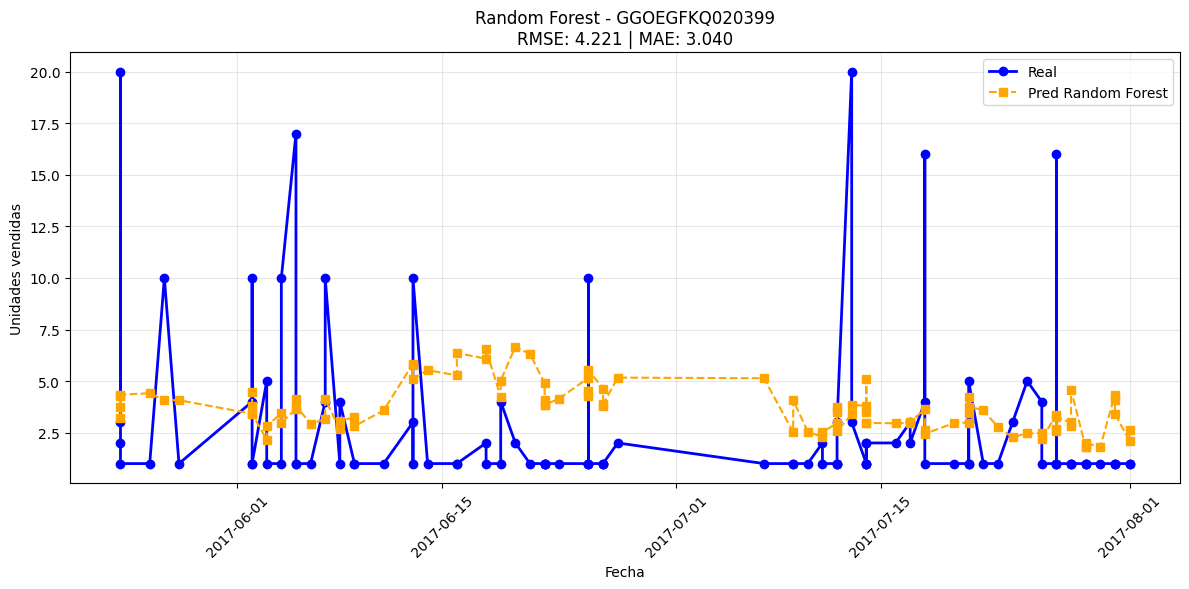

In [39]:
# 5. Visualización predicciones vs reales
import matplotlib.pyplot as plt

# Seleccionar un producto del set de test
test_products = df_sorted[test_mask]['product_sku'].value_counts().head(1)

for product_sku in test_products.index:
    product_mask = (df_sorted.loc[test_mask, 'product_sku'] == product_sku)
    
    if product_mask.sum() > 1:
        # Filtrar datos reales y predichos SOLO en test
        y_real_product = y_test[product_mask]
        y_pred_product = y_pred[product_mask.values]  # asegurar alineación con numpy
        dates_product = df_sorted.loc[test_mask, 'parsed_date'][product_mask]
        
        # Graficar
        plt.figure(figsize=(12, 6))
        plt.plot(dates_product, y_real_product, label="Real", marker="o", color="blue", linewidth=2)
        plt.plot(dates_product, y_pred_product, label="Pred Random Forest", marker="s", color="orange", linestyle="--")
        
        plt.title(f"Random Forest - {product_sku}\nRMSE: {rmse:.3f} | MAE: {mae:.3f}")
        plt.xlabel("Fecha")
        plt.ylabel("Unidades vendidas")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


### Conclusión: Experimento 1 - Random Forest

**Resultados obtenidos:**
- MAE  : ~3.040  
- RMSE : ~4.221  

**Observaciones:**
- El modelo logra predecir con un error promedio de unas **3 unidades por transacción**, lo cual es aceptable para el nivel de granularidad (día/producto/transacción).  
- El RMSE también es bajo, lo que indica que los errores grandes no son tan frecuentes.  
- Sin embargo, al ser un modelo basado en bagging, puede tener limitaciones para capturar patrones temporales complejos o dependencias largas en las series de cada producto.  

### Experimento 2 - LightGBM

In [10]:
# ------------------------------
# EXPERIMENTO 2 - LIGHTGBM
# ------------------------------
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt  

print("ENTRENANDO LIGHTGBM")

ENTRENANDO LIGHTGBM


In [11]:
# 1. DIVIDIR DATOS
df_sorted = df_filtered.sort_values("parsed_date")
split_date = df_sorted["parsed_date"].quantile(0.8)

train_mask = df_sorted["parsed_date"] <= split_date
test_mask = df_sorted["parsed_date"] > split_date

X_train = df_sorted.loc[train_mask, available_features]
X_test = df_sorted.loc[test_mask, available_features]
y_train = df_sorted.loc[train_mask, "units_sold"]
y_test = df_sorted.loc[test_mask, "units_sold"]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 14121, Test: 3495


In [12]:
# 2. MODELO LIGHTGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 14121, number of used features: 20
[LightGBM] [Info] Start training from score 3.392394


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              n_jobs=-1, random_state=42, subsample=0.8)

In [13]:
# 3. PREDICCIONES
y_pred_lgb = lgb_model.predict(X_test)

In [33]:
# 4. MÉTRICAS
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print("RESULTADOS LIGHTGBM")
print(f"MAE  : {mae_lgb:.3f}")
print(f"RMSE : {rmse_lgb:.3f}")

RESULTADOS LIGHTGBM
MAE  : 2.845
RMSE : 4.220


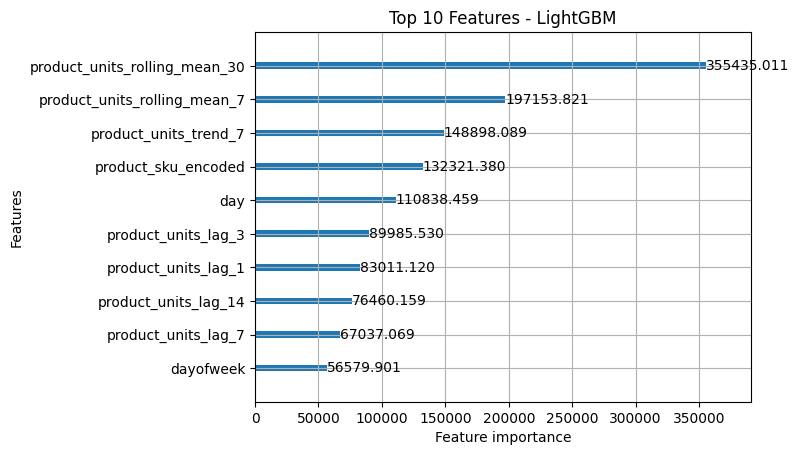

In [15]:
# 5. FEATURE IMPORTANCE
lgb.plot_importance(lgb_model, max_num_features=10, importance_type="gain")
plt.title("Top 10 Features - LightGBM")
plt.show()

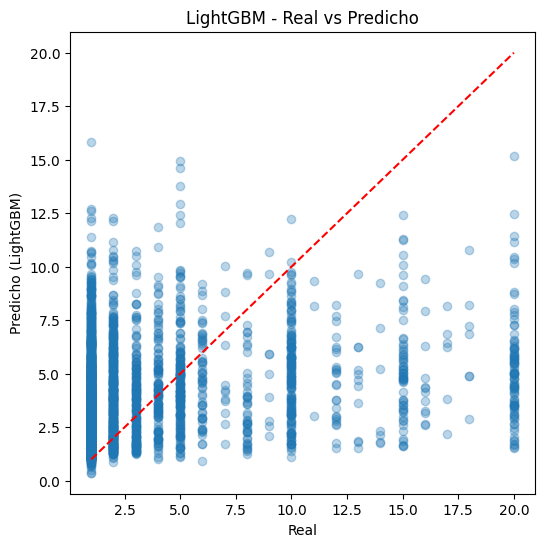

In [31]:
# ------------------------------
# SCATTER: REAL vs PREDICHO
# ------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # línea ideal

plt.xlabel("Real")
plt.ylabel("Predicho (LightGBM)")
plt.title("LightGBM - Real vs Predicho")
plt.show()


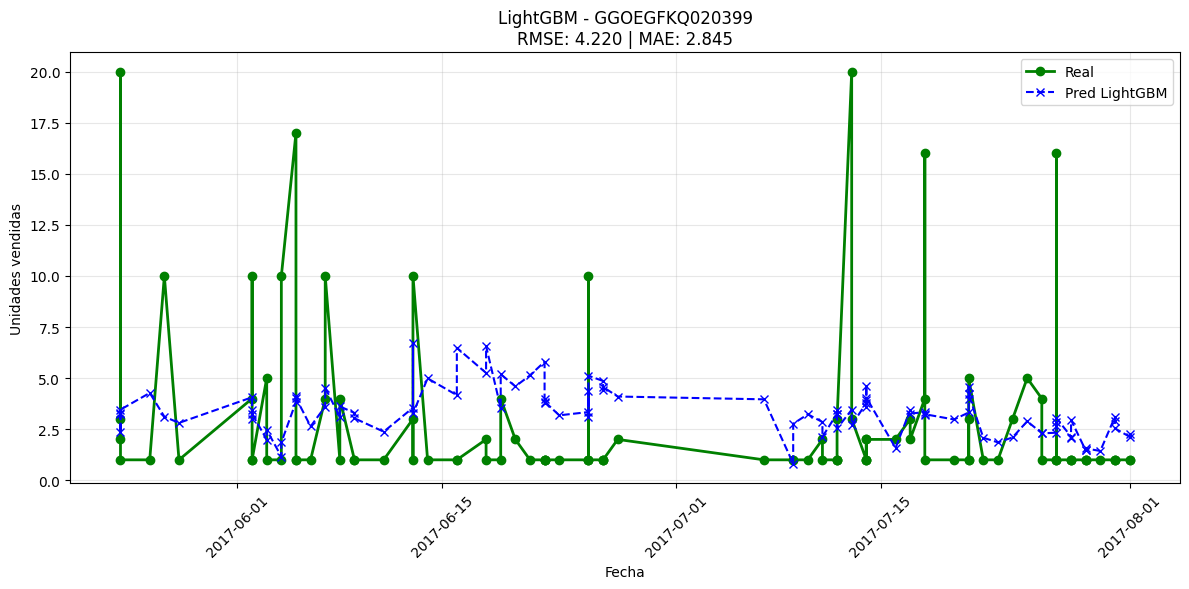

In [32]:
# ------------------------------
# VISUALIZACIÓN POR PRODUCTO (LightGBM)
# ------------------------------

test_indices = df_sorted[test_mask].index
test_products = df_sorted[test_mask]['product_sku'].value_counts().head(3)

for product_sku, count in test_products.items():
    product_mask = (df_sorted['product_sku'] == product_sku) & test_mask
    if product_mask.sum() > 1:
        product_test_indices = df_sorted[product_mask].index
        mask_positions = [i for i, idx in enumerate(test_indices) if idx in product_test_indices]
        
        y_real_product = y_test.loc[product_test_indices]
        y_pred_product = y_pred_lgb[mask_positions]
        dates_product = df_sorted.loc[product_test_indices, 'parsed_date']
        
        plt.figure(figsize=(12, 6))
        plt.plot(dates_product, y_real_product, label='Real', marker='o', color='green', linewidth=2)
        plt.plot(dates_product, y_pred_product, label='Pred LightGBM', marker='x', color='blue', linestyle='--')
        plt.title(f'LightGBM - {product_sku}\nRMSE: {rmse_lgb:.3f} | MAE: {mae_lgb:.3f}')
        plt.xlabel('Fecha')
        plt.ylabel('Unidades vendidas')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        break


### Conclusión: Experimento 2 - LightGBM

**Resultados obtenidos:**
- MAE  : ~2.845  
- RMSE : ~4.220  

**Observaciones:**
- LightGBM logra un **error promedio ligeramente menor** que Random Forest, indicando que las predicciones tienden a estar más cerca del valor real por transacción.  
- El RMSE se mantiene similar, lo que sugiere que los errores grandes no cambian significativamente respecto al modelo anterior.  
- La importancia de features muestra que las variables de **lags y rolling mean** son las más influyentes, confirmando que el historial de ventas es crítico para predecir la demanda a nivel día/producto.  
- LightGBM es **rápido y eficiente**, y se adapta bien a datos granulares, lo que lo hace un buen candidato para el pipeline de predicción.  

**Evaluación visual:**
- En la comparación **real vs. predicción (muestra de 200 puntos)**, LightGBM sigue las tendencias generales pero **suaviza los picos de ventas**, subestimando valores extremos.  
- El **scatter real vs. predicho** confirma que la mayoría de los puntos están cerca de la diagonal, pero con cierta dispersión en ventas altas.  

 Esto refuerza la idea de que, aunque LightGBM es competitivo, aún tiene margen de mejora en la captura de picos de demanda.  
